In [1]:
import pandas as pd 
import numpy as np 
import xlrd
import missingno as msg 
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats

import os
from sklearn.model_selection import train_test_split , cross_val_score , RandomizedSearchCV
from sklearn.preprocessing import StandardScaler ,MinMaxScaler ,LabelEncoder
from sklearn.metrics import accuracy_score,recall_score,precision_score,precision_recall_curve
from xgboost import XGBClassifier,plot_tree,plot_importance, XGBRegressor
from sklearn.ensemble import RandomForestClassifier

#from lightgbm import LGBMClassifier
#from catboost import CatBoostClassifier

from hyperopt import hp, tpe, Trials, STATUS_OK
from hyperopt import fmin
from sklearn.metrics import roc_auc_score, recall_score, precision_score, classification_report

# *Data Overview*

In [2]:
df = pd.read_excel('datac.xlsx')
df.head()

,Unnamed: 0,BBN,Pos,DH,Rock Type,BO,SO,B,S,NH,...,RTT,RTM,RTB,AL,MU,OV,TF,Di,BU,FE
0,1,19-27,West,8.5,Magnetite,4.30,5.30,4.5,5.5,22,...,Hard Ore,Hard Ore,Hard Ore,14.90,Type4,Type3,Type3,N,0.401576,69.598424
1,2,19-29,South,8.5,Magnetite,3.75,4.70,4.0,5.0,50,...,Hard Ore,Hard Ore,Hard Ore,14.10,Type4,Type3,Type5,N,0.643831,79.356169
2,3,13-341,North,8.5,Hematite,4.50,5.25,5.0,6.0,22,...,Soft Ore,Soft Ore,Soft Ore,13.22,Type4,Type4,Type4,Y,0.582149,89.417851
3,4,7-471,South West,8.5,Soil,5.80,8.05,6.0,8.0,62,...,Soil,Soil,Soil,14.93,Type5,Type5,Type1,N,0.000000,15.000000
4,5,8-362,South,8.5,Soil,6.10,8.40,6.5,8.5,63,...,Soil,Soil,Soil,16.24,Type7,Type1,Type1,N,0.000000,25.000000


In [3]:
# data describtion


In [4]:
df['Rock Type'].unique()

array(['Magnetite', 'Hematite', 'Soil', 'Waste Rock', 'Cong-Waste Rock',
       'Conglomerate', 'magn-Waste Rock', 'Soil-Cong', 'Soil-Waste Rock',
       'So-Co-Waste Rock'], dtype=object)

In [5]:
df['DH'].unique()

array([ 8.5, 10.5,  6.5,  7.5])

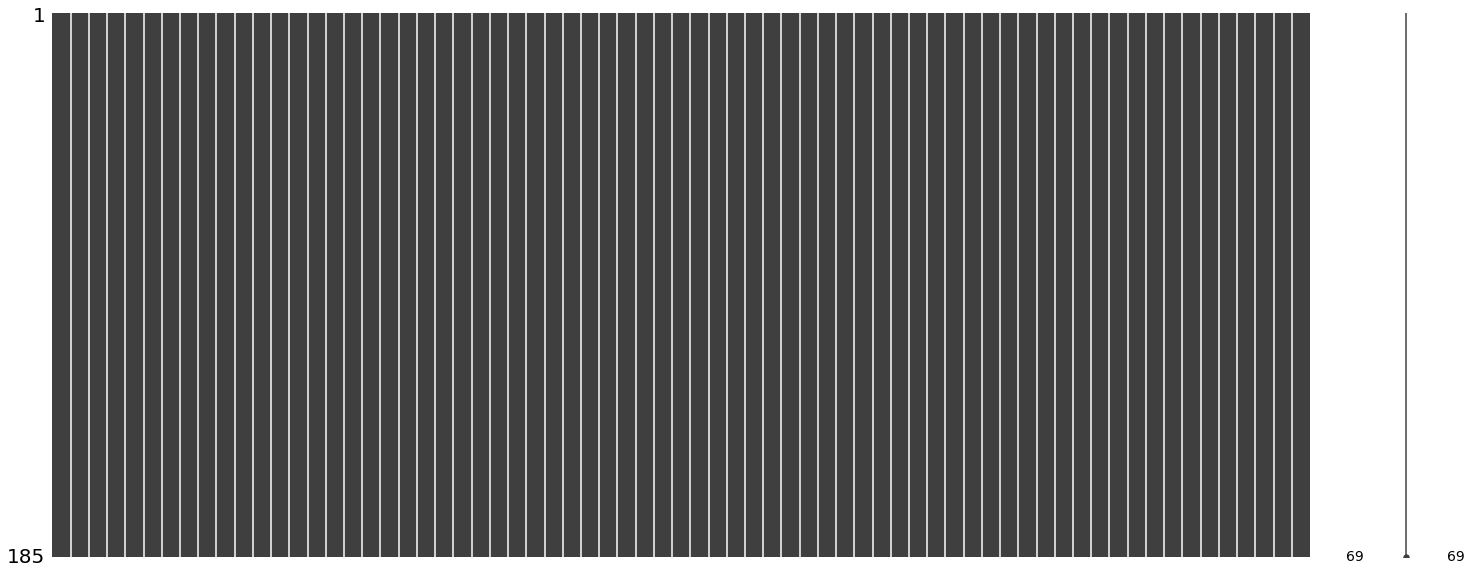

In [6]:
msg.matrix(df)

In [7]:
#df = df.drop('Name', axis=1)
describtion = pd.DataFrame(index=['observation(row)', 'percent missing','dtype','range'])
numerical = []
categorical = []
for col in df.columns:
    obs = df[col].size
    p_nan  = round(df[col].isna().sum()/obs,2)
    num_nan = f'{p_nan}% ({df[col].isna().sum()}/{obs})'
    dtype = 'categorical' if df[col].dtype == object else 'numerical'
    numerical.append(col) if dtype == 'numerical' else categorical.append(col)
    rng = f'{len(df[col].unique())} labels' if dtype == 'categorical' else f'{df[col].min()}-{df[col].max()}'
    describtion [col] = [obs,num_nan,dtype,rng]
pd.set_option('display.max_columns',100)
display(describtion)
#print(describtion)

,Unnamed: 0,BBN,Pos,DH,Rock Type,BO,SO,B,S,NH,TD,ST,CRUSHED,SD,ET,QAnfo,QAzar,QEmulan,SC,Initiation System,NBuster,Wbuster,Abuster,NEmulan,WEmulan,AEmulan,SP,Primer Situation,LF,LM,LL,WF,WM,WL,FailHF,FailHM,FailHL,AA1,AA2,AA3,AA4,AA5,AA6,BB1,BB2,BB3,BB4,BB5,BB6,RLW,DRCT,DRCM,DRCB,FDT,FDM,FDB,OFT,OFM,OFB,RTT,RTM,RTB,AL,MU,OV,TF,Di,BU,FE
observation(row),185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185
percent missing,0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185),0.0% (0/185)
dtype,numerical,categorical,categorical,numerical,categorical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,categorical,numerical,numerical,numerical,numerical,categorical,categorical,categorical,numerical,numerical,numerical,numerical,numerical,categorical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,numerical,categorical,categorical,categorical,categorical,numerical,numerical
range,1-185,185 labels,9 labels,6.5-10.5,10 labels,2.57-8.7,3.1-10.0,3.0-8.0,4.0-10.0,11-163,168.74-114912.0,3.6199999999999997-532.0,2811.2084-5405460.48,0.01397819401733296-0.11700717583070523,5 labels,0.0-2219126.4,0-3250,0.0-205049.6,0.2850343178668257-2.6145491630919335,3 labels,100 labels,5 labels,0.0-318.006,0-1098,0-2,0-2196,2.6639728573133512e-05-0.07119266622522101,3 labels,11.6-19.0,0.0-164.0,1.96-19.1,0.0-22.0,0.0-0.69,0.0-56.0,0-4,0-2,0-7,0-13,0-9,0-14,0-9,0-11,0-7,0-11,0-0,0-13,0-1,0-11,0-1,1.37-19.28,3 labels,3 labels,3 labels,3 labels,2 labels,2 labels,4 labels,4 labels,4 labels,6 labels,6 labels,6 labels,1.86-1596.0,10 labels,12 labels,8 labels,3 labels,0.0-25.0,0.0-95.0


[Text(0, 0, 'Magnetite'),
 Text(0, 0, 'Hematite'),
 Text(0, 0, 'Soil'),
 Text(0, 0, 'Waste Rock'),
 Text(0, 0, 'Cong-Waste Rock'),
 Text(0, 0, 'Conglomerate'),
 Text(0, 0, 'magn-Waste Rock'),
 Text(0, 0, 'Soil-Cong'),
 Text(0, 0, 'Soil-Waste Rock'),
 Text(0, 0, 'So-Co-Waste Rock')]

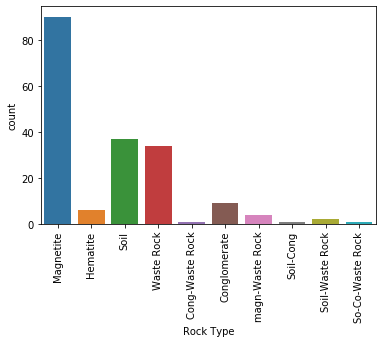

In [8]:
stone_plt = sns.countplot(x= 'Rock Type', data = df)
stone_plt.set_xticklabels(stone_plt.get_xticklabels(),rotation=90)

In [9]:
df1 = df.loc[(df['Rock Type'] == 'Magnetite') | (df['Rock Type'] == 'Hematite')]

In [10]:
#df = df.drop('Name', axis=1)
describtion = pd.DataFrame(index=['observation(row)', 'percent missing','dtype','range'])
numerical = []
categorical = []
for col in df1.columns:
    obs = df1[col].size
    p_nan  = round(df1[col].isna().sum()/obs,2)
    num_nan = f'{p_nan}% ({df1[col].isna().sum()}/{obs})'
    dtype = 'categorical' if df1[col].dtype == object else 'numerical'
    numerical.append(col) if dtype == 'numerical' else categorical.append(col)
    rng = f'{len(df1[col].unique())} labels' if dtype == 'categorical' else f'{df1[col].min()}-{df1[col].max()}'
    describtion [col] = [obs,num_nan,dtype,rng]
pd.set_option('display.max_columns',100)
display(describtion)
#print(describtion)

,Unnamed: 0,BBN,Pos,DH,Rock Type,BO,SO,B,S,NH,TD,ST,CRUSHED,SD,ET,QAnfo,QAzar,QEmulan,SC,Initiation System,NBuster,Wbuster,Abuster,NEmulan,WEmulan,AEmulan,SP,Primer Situation,LF,LM,LL,WF,WM,WL,FailHF,FailHM,FailHL,AA1,AA2,AA3,AA4,AA5,AA6,BB1,BB2,BB3,BB4,BB5,BB6,RLW,DRCT,DRCM,DRCB,FDT,FDM,FDB,OFT,OFM,OFB,RTT,RTM,RTB,AL,MU,OV,TF,Di,BU,FE
observation(row),96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96
percent missing,0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96),0.0% (0/96)
dtype,numerical,categorical,categorical,numerical,categorical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,categorical,numerical,numerical,numerical,numerical,categorical,categorical,categorical,numerical,numerical,numerical,numerical,numerical,categorical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,numerical,categorical,categorical,categorical,categorical,numerical,numerical
range,1-183,96 labels,8 labels,6.5-8.5,2 labels,2.57-5.3,3.1-6.1,3.0-5.0,4.0-6.0,11-80,168.74-7406.0,3.6666666666666665-53.666666666666664,2811.2084-121828.69999999998,0.03287027295901301-0.11700717583070523,5 labels,0.0-21300.499999999996,0-3250,0.0-205049.6,0.679741760419525-2.6145491630919335,3 labels,76 labels,4 labels,14.949-318.006,0-80,0-2,0-160,0.0012682889992259626-0.07119266622522101,1 labels,11.6-19.0,0.0-164.0,1.96-18.5,0.0-22.0,0.0-0.69,0.0-0.72,0-3,0-2,0-7,0-13,0-7,0-12,0-6,0-7,0-6,0-4,0-0,0-12,0-1,0-11,0-0,1.37-14.5,2 labels,2 labels,2 labels,3 labels,2 labels,2 labels,2 labels,2 labels,2 labels,3 labels,3 labels,2 labels,11.0-161.0,8 labels,11 labels,8 labels,3 labels,0.0-25.0,30.000000000000004-95.0


# *analys variable :*

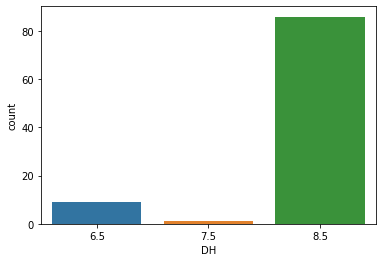

In [11]:
sns.countplot(df1['DH'])

In [12]:
df1 = df1.loc[df1['DH'] == 8.5]

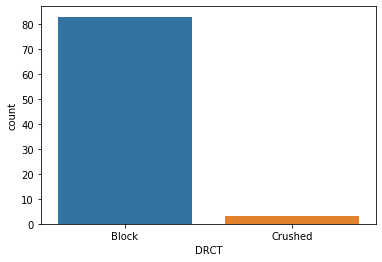

In [13]:
sns.countplot(df1['DRCT'])

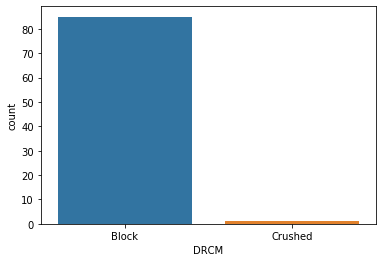

In [14]:
sns.countplot(df1['DRCM'])

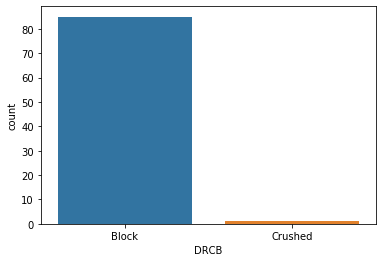

In [15]:
sns.countplot(df1['DRCB'])

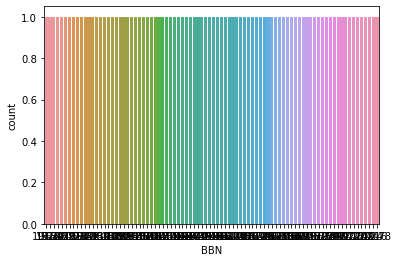

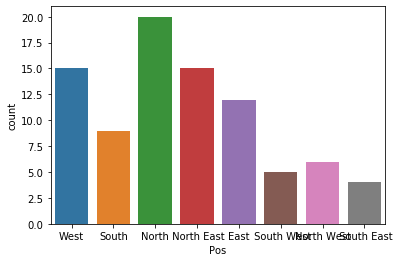

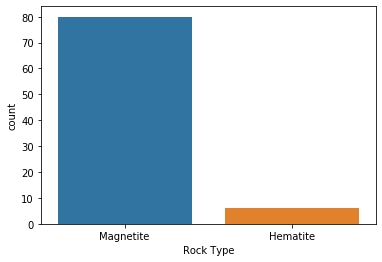

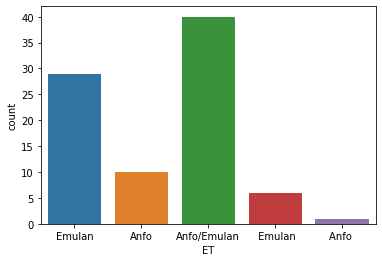

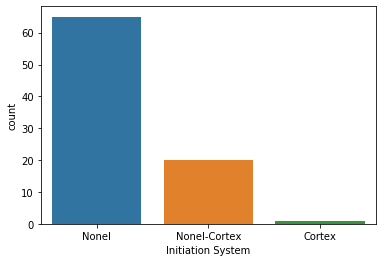

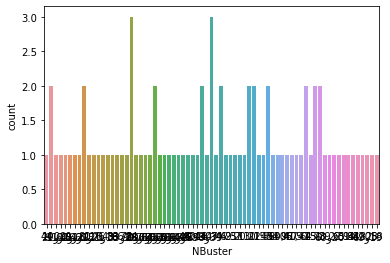

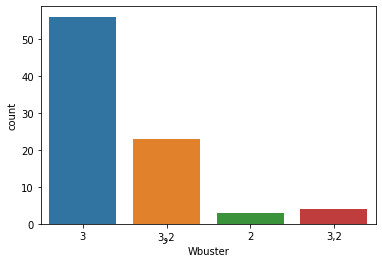

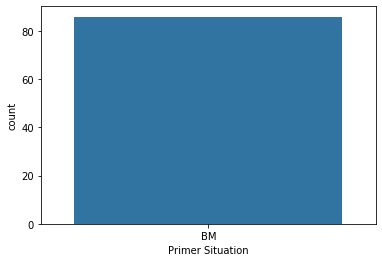

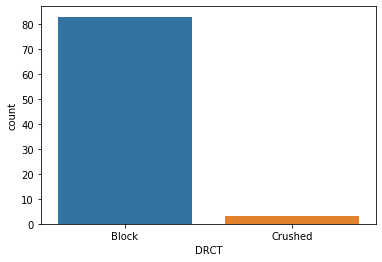

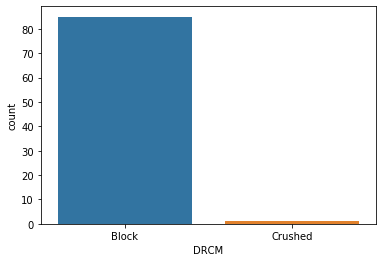

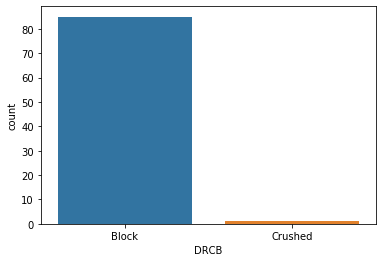

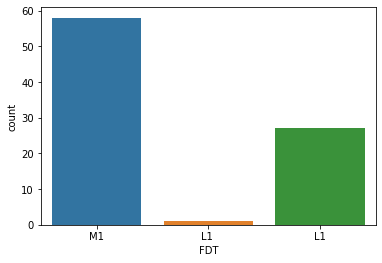

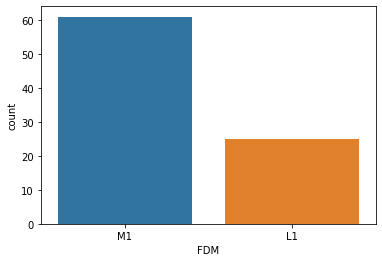

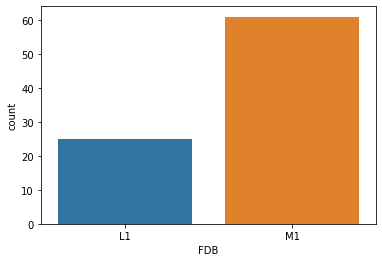

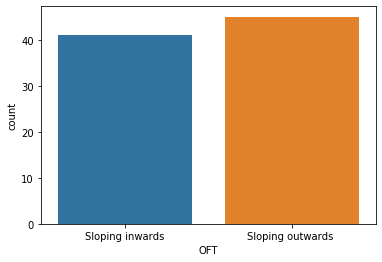

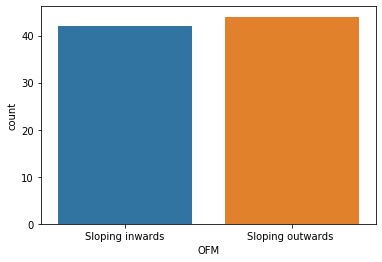

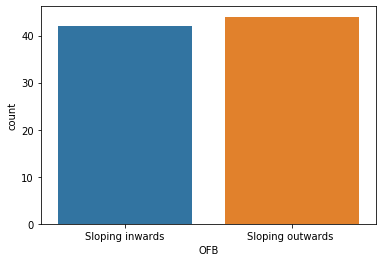

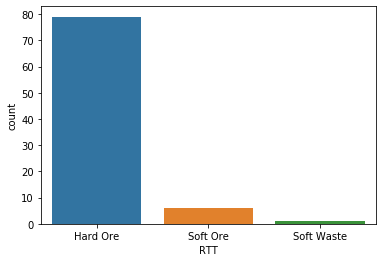

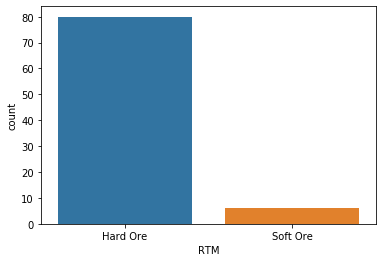

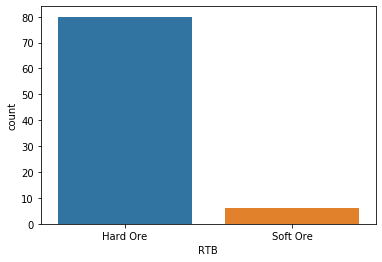

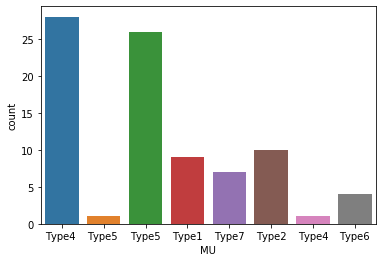

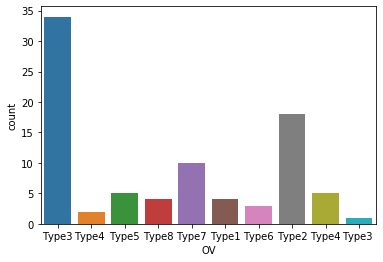

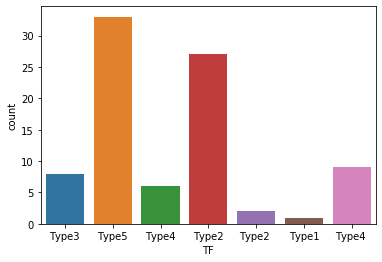

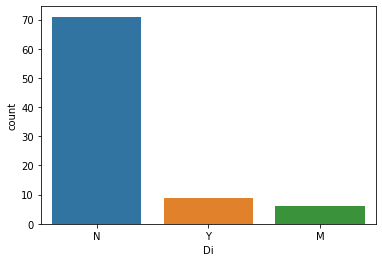

In [16]:
for i in categorical:
    sns.countplot(df1[i])
    plt.show()

# ***Analysis of skew & kurtosis***

In [17]:
for i in numerical: 
    if stats.skew(df1[i]) >-3 and stats.skew(df1[i]) <3 and stats.kurtosis(df1[i]) >-3 and stats.kurtosis(df1[i]) <3:
        print('skew of', i, 'is:', stats.skew(df1[i]))
        print('kurtosis of', i, 'is:', stats.kurtosis(df1[i]))
        print(i,'is OK')
    else:
        print('skew of', i, 'is:', stats.skew(df1[i]))
        print('kurtosis of', i, 'is:', stats.kurtosis(df1[i]))
        print(i,'is Fail')
        df1.drop([i], axis = 1 ,inplace = True)

skew of Unnamed: 0 is: 0.024542999528406894
kurtosis of Unnamed: 0 is: -1.2816979135473439
Unnamed: 0 is OK
skew of DH is: 0.0
kurtosis of DH is: -3.0
DH is Fail
skew of BO is: 0.7942410389595598
kurtosis of BO is: 2.6772414125928927
BO is OK
skew of SO is: -0.4792418502759056
kurtosis of SO is: 4.465218260536204
SO is Fail
skew of B is: 2.434845740731341
kurtosis of B is: 6.651412162953662
B is Fail
skew of S is: 2.434845740731341
kurtosis of S is: 6.651412162953662
S is Fail
skew of NH is: 0.6453183836456776
kurtosis of NH is: 0.1305086366895054
NH is OK
skew of TD is: 8.000575731556241
kurtosis of TD is: 67.88211047301671
TD is Fail
skew of ST is: 9.034288415460027
kurtosis of ST is: 80.09467461230928
ST is Fail
skew of CRUSHED is: 7.321874793346307
kurtosis of CRUSHED is: 59.361204458656005
CRUSHED is Fail
skew of SD is: 0.9941921723941333
kurtosis of SD is: 0.7923034182582049
SD is OK
skew of QAnfo is: 1.0774845014861711
kurtosis of QAnfo is: 1.0847409463769377
QAnfo is OK
skew of

In [18]:
for i in d:
    sns.distplot(df1[i], kde_kws={'bw': 0.1}) 
    plt.show()
d= ['BO','NH','SD','QAnfo','SC','Abuster','NEmulan','WEmulan','AEmulan','SP','LF','WM','WL','FailHF','AA5','RLW', 'Bu']


NameError: name 'd' is not defined

In [89]:
numerical = []
categorical = []
for col in df1.columns:
    dtype = 'categorical' if df1[col].dtype == object else 'numerical'
    numerical.append(col) if dtype == 'numerical' else categorical.append(col)

In [39]:
def org_results(trials, hyperparams, model_name):
    fit_idx = -1
    for idx, fit  in enumerate(trials):
        hyp = fit['misc']['vals']
        xgb_hyp = {key:[val] for key, val in hyperparams.items()}
        if hyp == xgb_hyp:
            fit_idx = idx
            break
            
    train_time = str(trials[-1]['refresh_time'] - trials[0]['book_time'])
    acc = round(trials[fit_idx]['result']['accuracy'], 3)
    train_auc = round(trials[fit_idx]['result']['train auc'], 3)
    test_auc = round(trials[fit_idx]['result']['test auc'], 3)

    results = {
        'model': model_name,
        'parameter search time': train_time,
        'accuracy': acc,
        'test auc score': test_auc,
        'training auc score': train_auc,
        'parameters': hyperparams
    }
    return results

In [40]:
d= ['BO','NH','SD','QAnfo','SC','Abuster','NEmulan','WEmulan','AEmulan','SP','LF','WM','WL','FailHF','AA5','RLW', 'Bu']

In [22]:
xgb_data = df.copy()

y_df = xgb_data['OFT'].reset_index(drop=True)
x_df = xgb_data[['BO','NH','SD','QAnfo','SC','WL','FailHF','AA5','RLW']]
train_x, test_x, train_y, test_y = train_test_split(x_df, y_df, test_size=0.2)

def xgb_objective(space, early_stopping_rounds=50):
    
    model = XGBClassifier(
        learning_rate = space['learning_rate'], 
        n_estimators = int(space['n_estimators']), 
        max_depth = int(space['max_depth']), 
        min_child_weight = space['m_child_weight'], 
        gamma = space['gamma'], 
        subsample = space['subsample'], 
        colsample_bytree = space['colsample_bytree'],
        objective = 'multi:softmax'
    )

    model.fit(train_x, train_y, 
              eval_set = [(train_x, train_y), (test_x, test_y)],
              eval_metric = 'auc',
              early_stopping_rounds = early_stopping_rounds,
              verbose = False)
     
    predictions = model.predict(test_x)
    test_preds = model.predict_proba(test_x)[:,1]
    train_preds = model.predict_proba(train_x)[:,1]
    
    xgb_booster = model.get_booster()
    train_auc = roc_auc_score(train_y, train_preds)
    test_auc = roc_auc_score(test_y, test_preds)
    accuracy = accuracy_score(test_y, predictions) 

    return {'status': STATUS_OK, 'loss': 1-test_auc, 'accuracy': accuracy,
            'test auc': test_auc, 'train auc': train_auc
           }

space = {
    'n_estimators': hp.quniform('n_estimators', 50, 1000, 25),
    'max_depth': hp.quniform('max_depth', 1, 12, 1),
    'm_child_weight': hp.quniform('m_child_weight', 1, 6, 1),
    'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'learning_rate': hp.loguniform('learning_rate', np.log(.001), np.log(.3)),
    'colsample_bytree': hp.quniform('colsample_bytree', .5, 1, .1)
}

trials = Trials()
xgb_hyperparams = fmin(fn = xgb_objective, 
                 max_evals = 150, 
                 trials = trials,
                 algo = tpe.suggest,
                 space = space
                 )

xgb_results = org_results(trials.trials, xgb_hyperparams, 'XGBoost')
display(xgb_results)


  0%|          | 0/150 [00:00<?, ?trial/s, best loss=?]job exception: [11:26:44] C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\metric\rank_metric.cc:243: Check failed: preds.Size() == info.labels_.Size() (592 vs. 148) : label size predict size not match

  0%|          | 0/150 [00:00<?, ?trial/s, best loss=?]


XGBoostError: [11:26:44] C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\metric\rank_metric.cc:243: Check failed: preds.Size() == info.labels_.Size() (592 vs. 148) : label size predict size not match

In [22]:
xgb_data = df1.copy()

y_df = xgb_data['OFT'].reset_index(drop=True)
x_df = xgb_data[['BO','NH','SD','QAnfo','SC','Abuster','NEmulan','WEmulan','AEmulan','SP','LF','WM','WL','FailHF','AA5','RLW']]
train_x, test_x, train_y, test_y = train_test_split(x_df, y_df, test_size=0.20,random_state = 42)
model = XGBClassifier()

In [23]:
df1['OFT'].unique()

array(['Sloping inwards', 'Sloping outwards '], dtype=object)

In [24]:
model.fit(train_x, train_y)   
predictions = model.predict(test_x)
test_preds = model.predict_proba(test_x)
train_preds = model.predict_proba(train_x)

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict,cross_val_score

In [26]:
y_train_pred = cross_val_predict(model,train_x,train_y,cv=3)

In [27]:
cm=confusion_matrix(train_y,y_train_pred)
cm

array([[21, 12],
       [14, 21]], dtype=int64)

[Text(0, 0.5, 'Sloping inwards'), Text(0, 1.5, 'Sloping outwards')]

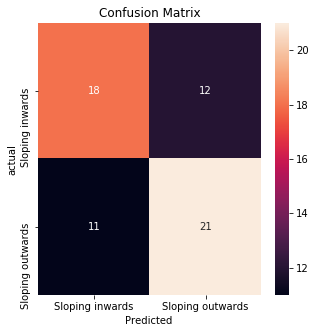

In [135]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted ');ax.set_ylabel('actual'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Sloping inwards', 'Sloping outwards'])
ax.yaxis.set_ticklabels(['Sloping inwards', 'Sloping outwards'])

[Text(0, 0.5, 'Sloping inwards'), Text(0, 1.5, 'Sloping outwards')]

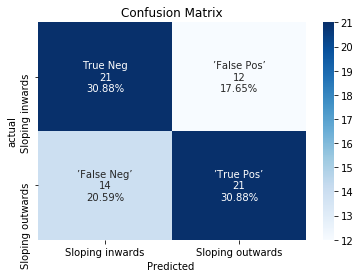

In [28]:
ax= plt.subplot()
group_names = ['True Neg','’False Pos’','’False Neg’','’True Pos’']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues',ax = ax)
ax.set_xlabel('Predicted ');ax.set_ylabel('actual'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Sloping inwards', 'Sloping outwards'])
ax.yaxis.set_ticklabels(['Sloping inwards', 'Sloping outwards'])

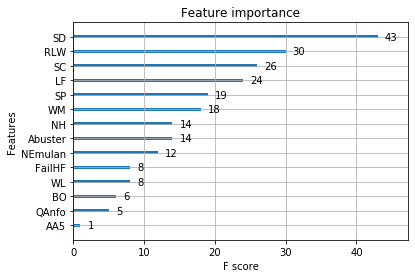

In [29]:
import xgboost as xgb
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [148]:
recall_score(train_y,y_train_pred,pos_label='Sloping inwards')

0.6

In [149]:
recall_score(train_y,y_train_pred,pos_label='Sloping outwards')

0.65625

In [152]:
print(classification_report(train_y,y_train_pred))

                  precision    recall  f1-score   support

 Sloping inwards       0.62      0.60      0.61        30
Sloping outwards       0.64      0.66      0.65        32

        accuracy                           0.63        62
       macro avg       0.63      0.63      0.63        62
    weighted avg       0.63      0.63      0.63        62

